# 대규모 언어 모델의 잠재력을 끌어내는 RAG 활용법
## **랭체인** 구성과 파이프라인 설정하기
<img src='https://raw.githubusercontent.com/corazzon/Mastering-NLP-from-Foundations-to-LLMs/refs/heads/main/cover.png'
     alt="NLP와 LLM 실전 가이드(한빛미디어)"
     style="border: 3px solid gray; box-shadow: 5px 5px 15px rgba(0, 0, 0, 0.3); border-radius: 10px; width: 300px;"   width='300'>

* 저자:  
    - [Lior Gazit](https://www.linkedin.com/in/liorgazit).  
    - [Meysam Ghaffari](https://www.linkedin.com/in/meysam-ghaffari-ph-d-a2553088/).
* 역자:
    - [박조은](https://github.com/corazzon)
* 이 노트북은 다음의 책에서 소개하는 내용입니다.
    - 역서 : NLP와 LLM 실전 가이드(한빛미디어)
    - 원서 : [Mastering NLP from Foundations to LLMs](https://www.amazon.com/dp/1804619183)

colab 실습 :
https://github.com/corazzon/Mastering-NLP-from-Foundations-to-LLMs

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/corazzon/Mastering-NLP-from-Foundations-to-LLMs/blob/main/Chapter8_notebooks/Ch8_Setting_Up_LangChain_Configurations_and_Pipeline.ipynb)  


원서 Colab 실습 :
https://github.com/PacktPublishing/Mastering-NLP-from-Foundations-to-LLMs   


<a target="_blank" href="https://colab.research.google.com/github/PacktPublishing/Mastering-NLP-from-Foundations-to-LLMs/blob/liors_branch/Chapter8_notebooks/Ch8_Setting_Up_LangChain_Configurations_and_Pipeline.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

**이 노트북의 목적:**  
이 노트북은 **LangChain**을 사용한 의미 검색 파이프라인 구축에 중점을 둡니다.  
의사가 환자 기록을 검색하고 다음과 같은 질문을 통해 환자를 찾을 수 있는 방법을 보여줍니다:  

`"최근에 여행을 다녀 온 환자는 누구입니까?"`  

의사의 진료 기록에서 내부 검색이 가능하도록 **임베딩**과 이를 **벡터 데이터베이스**에 저장하는 완전한 **RAG** 파이프라인을 구성합니다.  
LLM 없이 유사도 검색에만 기반한 이러한 파이프라인이 최적화되지 않았음을 보여줍니다.  
다음 노트북에서는 LLM을 통합하여 검색을 향상시키는 방법을 다룹니다:  
**Ch9_Advanced_LangChain_Configurations_and_Pipeline.ipynb**

**요구사항:**  
* Google Colab에서 실행 시, 다음 런타임 노트북 설정을 사용하세요: `Python3, CPU`

>*```면책사항: 이 노트북에서 다루는 내용과 아이디어는 저자들 개인의 것이며, 저자들의 고용주의 견해나 지적 재산을 대변하지 않습니다.```*

설정:

In [1]:
# 주의사항:
# 아래 코드에서 Python 패키지 불일치로 인한 오류가 발생하는 경우, 새로운 버전이 원인일 수 있습니다.
# 이런 경우, "default_installations"를 False로 설정하여 원래 이미지로 되돌리세요:
default_installations = True
if default_installations:
    !pip -q install langchain langchain-community
    !pip -q install sentence_transformers
    !pip -q install faiss-cpu
else:
    import requests
    text_file_path = "requirements__Ch8_Setting_Up_LangChain_Configurations_and_Pipeline.txt"
    url = "https://raw.githubusercontent.com/PacktPublishing/Mastering-NLP-from-Foundations-to-LLMs/main/Chapter8_notebooks/" + text_file_path
    res = requests.get(url)
    with open(text_file_path, "w") as f:
        f.write(res.text)

    !pip install -r requirements__Ch8_Setting_Up_LangChain_Configurations_and_Pipeline.txt

<img src="https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/65cd1db3881d5c33613395b6_Build%20Your%20App.webp" width="500">

<img src="https://python.langchain.com/assets/images/rag_indexing-8160f90a90a33253d0154659cf7d453f.png">

<img src="https://python.langchain.com/assets/images/rag_retrieval_generation-1046a4668d6bb08786ef73c56d4f228a.png">

이미지 출처 : https://python.langchain.com/docs/tutorials/rag/


Imports:

In [2]:
import requests
from langchain.document_loaders import TextLoader
import textwrap
from langchain.text_splitter import CharacterTextSplitter
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import FAISS

코드 설정:

### 가상 진료 기록이 담긴 텍스트 파일 불러오기
이 파일들은 우리가 활용하고자 하는 정보를 담고 있습니다.  
이번 예제에서는 로딩을 간단하고 빠르게 하기 위해 모든 가상 보고서를 하나의 CSV 테이블로 합쳤습니다.

#### 원서 내용

In [3]:
text_file_path = "mocked_up_physician_records.csv"
url = "https://raw.githubusercontent.com/PacktPublishing/Mastering-NLP-from-Foundations-to-LLMs/main/Chapter8_notebooks/" + text_file_path
res = requests.get(url)
with open(text_file_path, "w") as f:
    f.write(res.text)

In [4]:
print(res.text[:2000])

"Title: Mocked up record
Physician Name: Dr. ABC
Date: June 25, 2099
Patient ID: 987654321
Chief Complaint: Abdominal pain

History of Present Illness:
The patient, Mr. John Anderson, a 42-year-old male, presents today with a chief complaint of abdominal pain. He is married and resides with his wife and two children. Mr. Anderson recently returned from a business trip to Europe about two weeks ago. He denies any respiratory symptoms or exposure to sick individuals during his travel.

During the evaluation, Mr. Anderson revealed a pertinent family history of cardiovascular disease, with his father having suffered a myocardial infarction in his 60s. He also reports that his maternal grandmother had type 2 diabetes. Mr. Anderson denies any personal history of chronic illnesses, surgeries, or hospitalizations.

Regarding his chief complaint, Mr. Anderson describes the abdominal pain as a dull, intermittent ache located in the lower right quadrant. He rates the pain as 5 out of 10 in severi

### 한국어 버전

In [5]:
text_file_path = "mocked_up_physician_records_ko.csv"
url = "https://raw.githubusercontent.com/corazzon/Mastering-NLP-from-Foundations-to-LLMs/refs/heads/main/Chapter8_notebooks/" + text_file_path
res = requests.get(url)
with open(text_file_path, "w") as f:
    f.write(res.text)

In [6]:
print(res.text[:2000])

"Title: Mocked up record
담당의: ABC 의사
날짜: 2099년 6월 25일
환자 ID: 987654321
주 증상: 복통
현재 질환 이력:
환자 John Anderson 씨(42세, 남성)는 복통을 주 증상으로 내원하였습니다. 기혼자로 아내와 두 자녀와 함께 살고 있습니다. Anderson 씨는 약 2주 전 유럽 출장에서 돌아왔으며, 여행 중 호흡기 증상이나 아픈 사람과의 접촉은 없었다고 합니다.
진료 중 Anderson 씨는 아버지가 60대에 심근경색을 앓은 심혈관 질환 가족력이 있으며, 외할머니는 제2형 당뇨병을 앓았다고 밝혔습니다. 본인은 만성 질환, 수술 경험이나 입원 이력은 없다고 합니다.
주 증상에 대해 Anderson 씨는 우하복부에 둔하고 간헐적인 통증이 있으며, 통증 강도는 10점 만점에 5점 정도라고 설명합니다. 신체 활동 시 통증이 악화되고 식사 후에도 더 심해지는 경향이 있습니다. 구역질, 구토, 배변 습관의 변화와 같은 관련 증상은 없다고 합니다.
제공된 정보를 바탕으로 Anderson 씨의 복통 원인을 파악하기 위한 추가 평가와 진단 검사가 진행될 예정입니다."
"Title: Mocked up record
담당의: ABC 의사
날짜: 2099년 11월 15일
환자 ID: 123456789
주 증상: 피로감과 관절통
현재 질환 이력:
환자 Sarah Thompson 씨(57세, 여성)는 피로감과 관절통을 호소하며 내원하였습니다. 홀로 거주 중인 미망인으로, 최근 해외여행 이력은 없습니다.
진료 중 Thompson 씨는 자매가 류마티스 관절염 진단을 받은 자가면역 질환 가족력이 있다고 밝혔습니다. 또한 본인은 갑상선 기능 저하증이 있어 갑상선 호르몬 대체 요법으로 관리 중이라고 합니다.
주 증상에 대해 Thompson 씨는 일상 활동에 지장을 줄 정도로 지속적이고 심한 피로감을 느끼며, 그 정도는 10점 만점에 8점이라고 표현했습니다. 또한 주로 무릎과 손목에 관절통이 있는데, 아침에 더 심하고 하루 중 활동하면서 점

파일의 텍스트 내용 불러오기:

In [7]:
# 문서 불러오기
text_loader = TextLoader(text_file_path)
documents = text_loader.load()
documents

[Document(metadata={'source': 'mocked_up_physician_records_ko.csv'}, page_content='"Title: Mocked up record\n담당의: ABC 의사\n날짜: 2099년 6월 25일\n환자 ID: 987654321\n주 증상: 복통\n현재 질환 이력:\n환자 John Anderson 씨(42세, 남성)는 복통을 주 증상으로 내원하였습니다. 기혼자로 아내와 두 자녀와 함께 살고 있습니다. Anderson 씨는 약 2주 전 유럽 출장에서 돌아왔으며, 여행 중 호흡기 증상이나 아픈 사람과의 접촉은 없었다고 합니다.\n진료 중 Anderson 씨는 아버지가 60대에 심근경색을 앓은 심혈관 질환 가족력이 있으며, 외할머니는 제2형 당뇨병을 앓았다고 밝혔습니다. 본인은 만성 질환, 수술 경험이나 입원 이력은 없다고 합니다.\n주 증상에 대해 Anderson 씨는 우하복부에 둔하고 간헐적인 통증이 있으며, 통증 강도는 10점 만점에 5점 정도라고 설명합니다. 신체 활동 시 통증이 악화되고 식사 후에도 더 심해지는 경향이 있습니다. 구역질, 구토, 배변 습관의 변화와 같은 관련 증상은 없다고 합니다.\n제공된 정보를 바탕으로 Anderson 씨의 복통 원인을 파악하기 위한 추가 평가와 진단 검사가 진행될 예정입니다."\n"Title: Mocked up record\n담당의: ABC 의사\n날짜: 2099년 11월 15일\n환자 ID: 123456789\n주 증상: 피로감과 관절통\n현재 질환 이력:\n환자 Sarah Thompson 씨(57세, 여성)는 피로감과 관절통을 호소하며 내원하였습니다. 홀로 거주 중인 미망인으로, 최근 해외여행 이력은 없습니다.\n진료 중 Thompson 씨는 자매가 류마티스 관절염 진단을 받은 자가면역 질환 가족력이 있다고 밝혔습니다. 또한 본인은 갑상선 기능 저하증이 있어 갑상선 호르몬 대체 요법으로 관리 중이라고 합니다.\n주 증상에 대해 Thompson 씨는 일상 활동에 지장

랭체인 변수 유형을 살펴보기 (데이터 조작 방법을 알기 위해 유용합니다)

In [8]:
print(type(documents[0]))

<class 'langchain_core.documents.base.Document'>


원본 텍스트에 접근하는 예제를 살펴보겠습니다.

In [9]:
print(documents[0].page_content[0:200])

"Title: Mocked up record
담당의: ABC 의사
날짜: 2099년 6월 25일
환자 ID: 987654321
주 증상: 복통
현재 질환 이력:
환자 John Anderson 씨(42세, 남성)는 복통을 주 증상으로 내원하였습니다. 기혼자로 아내와 두 자녀와 함께 살고 있습니다. Anderson 씨는 약 2주 전 유럽 출장에서 돌아왔으며, 


In [10]:
print(documents[0].page_content[200:400])

여행 중 호흡기 증상이나 아픈 사람과의 접촉은 없었다고 합니다.
진료 중 Anderson 씨는 아버지가 60대에 심근경색을 앓은 심혈관 질환 가족력이 있으며, 외할머니는 제2형 당뇨병을 앓았다고 밝혔습니다. 본인은 만성 질환, 수술 경험이나 입원 이력은 없다고 합니다.
주 증상에 대해 Anderson 씨는 우하복부에 둔하고 간헐적인 통증이 있으며, 통증 강


### 임베딩을 위한 데이터 전처리

In [11]:
# 우리가 사용하는 데이터 파일에서는 이 짧은 문자열이 서로 다른 임상 보고서들을 구분하는 구분자입니다:
split_text_by = '"Title: Mocked up record'
chunk_size = 700
chunk_overlap = 0

In [12]:
# 텍스트 나누기
text_splitter = CharacterTextSplitter(chunk_size=chunk_size,
                                      chunk_overlap=chunk_overlap,
                                      separator=split_text_by)
splitted_docs = text_splitter.split_documents(documents)

In [13]:
len(splitted_docs)

4

In [14]:
print(splitted_docs[0].page_content)

담당의: ABC 의사
날짜: 2099년 6월 25일
환자 ID: 987654321
주 증상: 복통
현재 질환 이력:
환자 John Anderson 씨(42세, 남성)는 복통을 주 증상으로 내원하였습니다. 기혼자로 아내와 두 자녀와 함께 살고 있습니다. Anderson 씨는 약 2주 전 유럽 출장에서 돌아왔으며, 여행 중 호흡기 증상이나 아픈 사람과의 접촉은 없었다고 합니다.
진료 중 Anderson 씨는 아버지가 60대에 심근경색을 앓은 심혈관 질환 가족력이 있으며, 외할머니는 제2형 당뇨병을 앓았다고 밝혔습니다. 본인은 만성 질환, 수술 경험이나 입원 이력은 없다고 합니다.
주 증상에 대해 Anderson 씨는 우하복부에 둔하고 간헐적인 통증이 있으며, 통증 강도는 10점 만점에 5점 정도라고 설명합니다. 신체 활동 시 통증이 악화되고 식사 후에도 더 심해지는 경향이 있습니다. 구역질, 구토, 배변 습관의 변화와 같은 관련 증상은 없다고 합니다.
제공된 정보를 바탕으로 Anderson 씨의 복통 원인을 파악하기 위한 추가 평가와 진단 검사가 진행될 예정입니다."


In [15]:
print(splitted_docs[1].page_content)

담당의: ABC 의사
날짜: 2099년 11월 15일
환자 ID: 123456789
주 증상: 피로감과 관절통
현재 질환 이력:
환자 Sarah Thompson 씨(57세, 여성)는 피로감과 관절통을 호소하며 내원하였습니다. 홀로 거주 중인 미망인으로, 최근 해외여행 이력은 없습니다.
진료 중 Thompson 씨는 자매가 류마티스 관절염 진단을 받은 자가면역 질환 가족력이 있다고 밝혔습니다. 또한 본인은 갑상선 기능 저하증이 있어 갑상선 호르몬 대체 요법으로 관리 중이라고 합니다.
주 증상에 대해 Thompson 씨는 일상 활동에 지장을 줄 정도로 지속적이고 심한 피로감을 느끼며, 그 정도는 10점 만점에 8점이라고 표현했습니다. 또한 주로 무릎과 손목에 관절통이 있는데, 아침에 더 심하고 하루 중 활동하면서 점차 나아진다고 합니다. 관절 부위의 붓기나 붉어짐은 없다고 합니다.
임상 소견을 바탕으로 Thompson 씨의 피로감과 관절통의 원인을 찾기 위한 추가 검사가 필요합니다. 혈액 검사, 영상 검사 및 필요시 전문의 상담을 진행할 예정입니다."


In [16]:
print(splitted_docs[2].page_content)

담당의: ABC 의사
날짜: 2099년 11월 28일
환자 ID: 987654321
주 증상: 편두통
현재 질환 이력:
환자 Michael Johnson 씨(40세, 남성)는 반복되는 편두통을 주 증상으로 내원하였습니다. 기혼자로 배우자와 두 자녀와 함께 살고 있으며, 최근 지역 외 여행은 하지 않았습니다.
진료 중 Johnson 씨는 어머니와 여동생도 비슷한 증상의 편두통을 앓고 있는 가족력이 있다고 밝혔습니다. 중요한 과거 병력, 수술이나 입원 경험은 없다고 합니다. 업무가 바빠 가끔 스트레스를 받고 수면 패턴이 불규칙하다고 언급했습니다.
주 증상에 대해 Johnson 씨는 주로 머리 한쪽에 중간에서 심한 정도의 욱신거리는 통증이 반복적으로 나타난다고 설명합니다. 빛과 소리에 민감해지고 구역질이 나며 때로는 구토도 한다고 합니다. 편두통은 보통 몇 시간 지속되며 한 달에 한두 번 발생한다고 합니다.
제공된 정보를 바탕으로 Johnson 씨의 편두통 관리를 위한 추가 평가가 이루어질 예정입니다. 두통의 빈도, 지속 시간 및 유발 요인을 추적하기 위한 두통 일기 작성을 권장할 것이며, 증상 완화와 삶의 질 향상을 위한 생활 습관 개선, 스트레스 관리 방법, 적절한 약물 치료에 대해 상담할 예정입니다."


In [17]:
print(splitted_docs[3].page_content)

담당의: ABC 의사
날짜: 2099년 7월 10일
환자 ID: 246813579
주 증상: 임신 정기 검진
현재 질환 이력:
환자 Emily Adams 씨(30세, 여성)는 정기 임신 검진을 위해 내원하였습니다. 현재 임신 32주차로, 2099년 8월 27일이 출산 예정일입니다. 기혼자로 남편과 함께 살고 있습니다.
진료 중 Adams 씨는 어머니가 임신 중 임신성 당뇨를 앓았던 가족력이 있다고 밝혔습니다. 본인은 중요한 병력이나 수술 경험, 이전 임신에서의 합병증은 없다고 합니다.
주 증상에 대해 Adams 씨는 임신 3기에 흔히 나타나는 요통, 잦은 소변, 가끔의 속쓰림 등의 불편함을 호소합니다. 질 출혈, 심한 복통, 태아 움직임의 특이한 변화는 없다고 합니다. 임신 중 전반적인 건강 관리를 위해 균형 잡힌 식단과 규칙적인 운동을 유지하고 있다고 합니다.
제공된 정보를 바탕으로 Adams 씨의 임신 경과를 확인하기 위한 정기 산전 검사가 진행될 예정입니다. 혈압, 체중 증가, 자궁저 높이 측정, 태아 심장 박동 모니터링 등을 평가할 것입니다. 건강한 출산과 순조로운 육아를 위해 출산 준비, 모유 수유, 산후 관리에 대한 상담도 함께 이루어질 예정입니다."


### 벡터 데이터베이스에 저장할 임베딩 생성  
허깅페이스의 오픈 소스 모델을 사용합니다.
* https://huggingface.co/sentence-transformers/all-mpnet-base-v2
* MPNet은 BERT, RoBERTa, XLNet 등의 장점을 융합한 최신 Transformer 모델입니다.
* 한국어로는 https://huggingface.co/upskyy/e5-small-korean 를 사용해 봅니다.

In [18]:
# embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2")
embeddings = HuggingFaceEmbeddings(model_name="upskyy/e5-small-korean")

<ipython-input-18-4901b9960a1f>:2: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings = HuggingFaceEmbeddings(model_name="upskyy/e5-small-korean")
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warni

In [19]:
# 임베딩이 잘 되었는지 확인
# embedded_query = embeddings.embed_query("What was the name mentioned in the conversation?")
embedded_query = embeddings.embed_query("한국어 임베딩 모델을 사용합니다.")
embedded_query[:5]

[-0.06463496387004852,
 -0.20045262575149536,
 0.1640482395887375,
 -0.13611029088497162,
 0.24039965867996216]

### 벡터 데이터베이스 생성

<img src="https://python.langchain.com/assets/images/vectorstores-2540b4bc355b966c99b0f02cfdddb273.png">

* 출처 : https://python.langchain.com/docs/concepts/vectorstores/

벡터 데이터베이스로는 FAISS(Facebook AI Similarity Search)를 선택했습니다:

자세한 내용은 다음 링크를 참조하세요:

* https://python.langchain.com/docs/integrations/vectorstores/
* https://python.langchain.com/v0.1/docs/integrations/vectorstores/faiss/#:~:text=Now%2C%20we%20can%20query%20the,similarity_search

In [20]:
vector_db = FAISS.from_documents(splitted_docs, embeddings)
vector_db

In [21]:
print(f"FAISS 내 문서 개수: {vector_db.index.ntotal}")

FAISS 내 문서 개수: 4


In [22]:
dimension = vector_db.index.d
print(f"벡터의 차원 수: {dimension}")

벡터의 차원 수: 384


전체 문서 수: 4


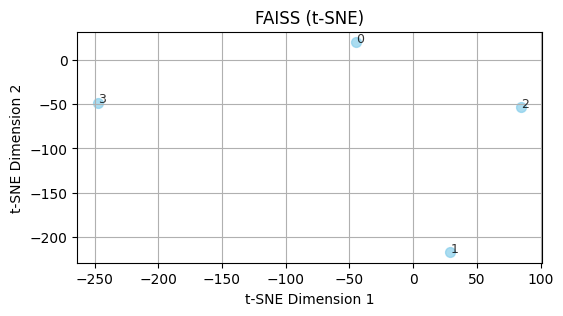

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# FAISS에서 벡터 데이터 추출
vectors = vector_db.index.reconstruct_n(0, vector_db.index.ntotal)

# 현재 문서 수 확인
n_samples = len(vectors)
print(f"전체 문서 수: {n_samples}")

# perplexity를 문서 개수보다 작게 설정 (예: 2)
tsne = TSNE(n_components=2, perplexity=min(2, n_samples - 1), random_state=42, metric='cosine')
embeddings_2d = tsne.fit_transform(np.array(vectors))

# 시각화
plt.figure(figsize=(6, 3))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c='skyblue', s=50, alpha=0.7)

# 문서 번호 표시
for i, (x, y) in enumerate(embeddings_2d):
    plt.text(x, y, str(i), fontsize=9, alpha=0.8)

plt.title('FAISS (t-SNE)')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.grid(True)
plt.show()


### 내부 문서를 활용한 유사도 검색 수행

**질문 #1: 8월에 출산 예정인 임산부 환자가 있나요?**  

In [24]:
# query1 = "Are there any pregnant patients who are due to deliver in August?"
query1 = "8월에 출산 예정인 임산부가 있나요?"
docs = vector_db.similarity_search(query1)
print(textwrap.fill(str(docs[0].page_content), width=100, replace_whitespace=False))

담당의: ABC 의사
날짜: 2099년 7월 10일
환자 ID: 246813579
주 증상: 임신 정기 검진
현재 질환 이력:
환자 Emily Adams 씨(30세, 여성)는 정기
임신 검진을 위해 내원하였습니다. 현재 임신 32주차로, 2099년 8월 27일이 출산 예정일입니다. 기혼자로 남편과 함께 살고 있습니다.
진료 중 Adams 씨는 어머니가 임신
중 임신성 당뇨를 앓았던 가족력이 있다고 밝혔습니다. 본인은 중요한 병력이나 수술 경험, 이전 임신에서의 합병증은 없다고 합니다.
주 증상에 대해 Adams 씨는 임신 3기에 흔히
나타나는 요통, 잦은 소변, 가끔의 속쓰림 등의 불편함을 호소합니다. 질 출혈, 심한 복통, 태아 움직임의 특이한 변화는 없다고 합니다. 임신 중 전반적인 건강 관리를 위해 균형
잡힌 식단과 규칙적인 운동을 유지하고 있다고 합니다.
제공된 정보를 바탕으로 Adams 씨의 임신 경과를 확인하기 위한 정기 산전 검사가 진행될 예정입니다. 혈압, 체중 증가,
자궁저 높이 측정, 태아 심장 박동 모니터링 등을 평가할 것입니다. 건강한 출산과 순조로운 육아를 위해 출산 준비, 모유 수유, 산후 관리에 대한 상담도 함께 이루어질
예정입니다."


**[오류의 예!] 질문 #2: 출산 예정일이 9월인 임산부가 있나요?**  
이것은 유사성 검색이 **틀린 결과**를 제공하는 예입니다.  
질문과 유사한 텍스트를 제공하긴 했지만, 이 사례는 유사성이 정답을 맞히는 것과는 다르다는 점을 보여줍니다.  

In [25]:
# query2 = "Are there any pregnant patients who are due to deliver in September?"
query2 = "9월에 출산 예정인 임산부가 있나요?"
docs = vector_db.similarity_search(query2, k=1)
print(textwrap.fill(str(docs[0].page_content), width=100, replace_whitespace=False))

담당의: ABC 의사
날짜: 2099년 7월 10일
환자 ID: 246813579
주 증상: 임신 정기 검진
현재 질환 이력:
환자 Emily Adams 씨(30세, 여성)는 정기
임신 검진을 위해 내원하였습니다. 현재 임신 32주차로, 2099년 8월 27일이 출산 예정일입니다. 기혼자로 남편과 함께 살고 있습니다.
진료 중 Adams 씨는 어머니가 임신
중 임신성 당뇨를 앓았던 가족력이 있다고 밝혔습니다. 본인은 중요한 병력이나 수술 경험, 이전 임신에서의 합병증은 없다고 합니다.
주 증상에 대해 Adams 씨는 임신 3기에 흔히
나타나는 요통, 잦은 소변, 가끔의 속쓰림 등의 불편함을 호소합니다. 질 출혈, 심한 복통, 태아 움직임의 특이한 변화는 없다고 합니다. 임신 중 전반적인 건강 관리를 위해 균형
잡힌 식단과 규칙적인 운동을 유지하고 있다고 합니다.
제공된 정보를 바탕으로 Adams 씨의 임신 경과를 확인하기 위한 정기 산전 검사가 진행될 예정입니다. 혈압, 체중 증가,
자궁저 높이 측정, 태아 심장 박동 모니터링 등을 평가할 것입니다. 건강한 출산과 순조로운 육아를 위해 출산 준비, 모유 수유, 산후 관리에 대한 상담도 함께 이루어질
예정입니다."


In [26]:
len(docs)

1

**질문 #3: 최근에 여행을 다녀온 환자는 누구인가요?**

In [27]:
# query3 = "Which patients have travelled recently?"
query3 = "최근에 여행을 다녀온 환자는 누구인가요?"
docs = vector_db.similarity_search(query3)
print(textwrap.fill(str(docs[0].page_content), width=100, replace_whitespace=False))

담당의: ABC 의사
날짜: 2099년 11월 15일
환자 ID: 123456789
주 증상: 피로감과 관절통
현재 질환 이력:
환자 Sarah Thompson 씨(57세,
여성)는 피로감과 관절통을 호소하며 내원하였습니다. 홀로 거주 중인 미망인으로, 최근 해외여행 이력은 없습니다.
진료 중 Thompson 씨는 자매가 류마티스 관절염 진단을 받은
자가면역 질환 가족력이 있다고 밝혔습니다. 또한 본인은 갑상선 기능 저하증이 있어 갑상선 호르몬 대체 요법으로 관리 중이라고 합니다.
주 증상에 대해 Thompson 씨는 일상
활동에 지장을 줄 정도로 지속적이고 심한 피로감을 느끼며, 그 정도는 10점 만점에 8점이라고 표현했습니다. 또한 주로 무릎과 손목에 관절통이 있는데, 아침에 더 심하고 하루 중
활동하면서 점차 나아진다고 합니다. 관절 부위의 붓기나 붉어짐은 없다고 합니다.
임상 소견을 바탕으로 Thompson 씨의 피로감과 관절통의 원인을 찾기 위한 추가 검사가
필요합니다. 혈액 검사, 영상 검사 및 필요시 전문의 상담을 진행할 예정입니다."


In [28]:
docs

[Document(id='3346e030-940d-43dd-9fcd-c98e6ea2eb6b', metadata={'source': 'mocked_up_physician_records_ko.csv'}, page_content='담당의: ABC 의사\n날짜: 2099년 11월 15일\n환자 ID: 123456789\n주 증상: 피로감과 관절통\n현재 질환 이력:\n환자 Sarah Thompson 씨(57세, 여성)는 피로감과 관절통을 호소하며 내원하였습니다. 홀로 거주 중인 미망인으로, 최근 해외여행 이력은 없습니다.\n진료 중 Thompson 씨는 자매가 류마티스 관절염 진단을 받은 자가면역 질환 가족력이 있다고 밝혔습니다. 또한 본인은 갑상선 기능 저하증이 있어 갑상선 호르몬 대체 요법으로 관리 중이라고 합니다.\n주 증상에 대해 Thompson 씨는 일상 활동에 지장을 줄 정도로 지속적이고 심한 피로감을 느끼며, 그 정도는 10점 만점에 8점이라고 표현했습니다. 또한 주로 무릎과 손목에 관절통이 있는데, 아침에 더 심하고 하루 중 활동하면서 점차 나아진다고 합니다. 관절 부위의 붓기나 붉어짐은 없다고 합니다.\n임상 소견을 바탕으로 Thompson 씨의 피로감과 관절통의 원인을 찾기 위한 추가 검사가 필요합니다. 혈액 검사, 영상 검사 및 필요시 전문의 상담을 진행할 예정입니다."'),
 Document(id='cf695f6f-7a86-400f-82ac-d1634cf212ec', metadata={'source': 'mocked_up_physician_records_ko.csv'}, page_content='담당의: ABC 의사\n날짜: 2099년 6월 25일\n환자 ID: 987654321\n주 증상: 복통\n현재 질환 이력:\n환자 John Anderson 씨(42세, 남성)는 복통을 주 증상으로 내원하였습니다. 기혼자로 아내와 두 자녀와 함께 살고 있습니다. Anderson 씨는 약 2주 전 유럽 출장에서 돌아왔으며, 여행 중 호흡기 증상이나 아픈 사람

**질문 #4: 검사실 검사가 필요한 환자는 누구인가요?**

In [29]:
# query4 = "Which patients require lab work?"
query4 = "검사실 검사가 필요한 환자는 누구인가요?"
docs = vector_db.similarity_search(query4)
print(textwrap.fill(str(docs[0].page_content), width=100, replace_whitespace=False))

담당의: ABC 의사
날짜: 2099년 11월 15일
환자 ID: 123456789
주 증상: 피로감과 관절통
현재 질환 이력:
환자 Sarah Thompson 씨(57세,
여성)는 피로감과 관절통을 호소하며 내원하였습니다. 홀로 거주 중인 미망인으로, 최근 해외여행 이력은 없습니다.
진료 중 Thompson 씨는 자매가 류마티스 관절염 진단을 받은
자가면역 질환 가족력이 있다고 밝혔습니다. 또한 본인은 갑상선 기능 저하증이 있어 갑상선 호르몬 대체 요법으로 관리 중이라고 합니다.
주 증상에 대해 Thompson 씨는 일상
활동에 지장을 줄 정도로 지속적이고 심한 피로감을 느끼며, 그 정도는 10점 만점에 8점이라고 표현했습니다. 또한 주로 무릎과 손목에 관절통이 있는데, 아침에 더 심하고 하루 중
활동하면서 점차 나아진다고 합니다. 관절 부위의 붓기나 붉어짐은 없다고 합니다.
임상 소견을 바탕으로 Thompson 씨의 피로감과 관절통의 원인을 찾기 위한 추가 검사가
필요합니다. 혈액 검사, 영상 검사 및 필요시 전문의 상담을 진행할 예정입니다."
